In [ ]:
import os, datetime, hashlib, subprocess, warnings
import numpy as np, pandas as pd
from sqlalchemy import create_engine, text
from scipy.special import expit
from collections import defaultdict
import tqdm
import json
from scipy import stats

In [ ]:
EXCLUDE = {"PI0", "PI0_FAST"} #, "PALIGEMMA_FAST_DROID", "PALIGEMMA_FAST_SPECIALIST_DROID", "PALIGEMMA_DIFFUSION_DROID", "PALIGEMMA_VQ_DROID"}
T_BUCKET = 8 # discrete task buckets
TEST_FR = 0.20
EM_ITERS = 60
VERBOSE = False
rng = np.random.default_rng(0)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# Helper functions

def canonical(x): return (x or "").strip()
def sha8(x): return hashlib.sha1(x.encode()).hexdigest()[:8]
def dbg(*a): print(*a) if VERBOSE else None
def safe_newton(x, g, h): return x - g / (h if abs(h) > 1e-8 else -1e-8)

def ci(scores, confidence=0.95):
    n = len(scores)
    sem = stats.sem(scores)  # Standard error of the mean
    ci = sem * stats.t.ppf((1 + confidence) / 2, n - 1)
    return ci

def pearson(a, b):
    a, b = np.asarray(a), np.asarray(b)
    m = ~(np.isnan(a) | np.isnan(b))
    if m.sum() < 2: return np.nan
    a, b = a[m] - a[m].mean(), b[m] - b[m].mean()
    return (a @ b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

def mmrv(a, b):
    a, b = np.asarray(a), np.asarray(b)
    m = ~(np.isnan(a) | np.isnan(b))
    if m.sum() < 2: return np.nan
    a, b = a[m], b[m]
    return np.mean([
        max([abs(b[i] - b[j]) for j in range(len(a))
             if (a[i] > a[j]) != (b[i] > b[j])] or [0])
        for i in range(len(a))
    ])

def accuracy(df, board):
    sc = board.set_index("policy")["score"]
    ok = 0
    total = 0
    for _, r in df.iterrows():
        if r.y == 1: continue   # Don't measure accuracy on ties
        if r.i in sc and r.j in sc:
            total += 1
            pred = 2 if sc[r.i] > sc[r.j] else 0 # if sc[r.j] > sc[r.i] else 1
            ok += int(pred == r.y)
    return ok / total

In [ ]:
import pandas as pd

eps = pd.read_csv("episodes.csv.gz", compression="gzip")
ses = pd.read_csv("sessions.csv.gz", compression="gzip")

In [ ]:
eps[-5:]

,id,session_id,policy_name,command,binary_success,partial_success,duration,gcs_left_cam_path,gcs_right_cam_path,gcs_wrist_cam_path,npz_file_path,policy_ip,policy_port,third_person_camera_type,third_person_camera_id,feedback,timestamp,policy_canon
4686,4687,922,paligemma_binning_droid,place the shoes inside the box,0,0.00,80,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,NaN,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,159.223.171.199,41782,left_image,NaN,B;avg_latency=1.688,2025-04-30 00:47:24,paligemma_binning_droid
4687,4689,922,paligemma_fast_specialist_droid,place the shoes inside the box,0,0.20,344,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,NaN,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,159.223.171.199,23203,left_image,NaN,D;avg_latency=0.874,2025-04-30 00:51:12,paligemma_fast_specialist_droid
4688,4691,922,paligemma_vq_droid,place the shoes inside the box,0,0.00,88,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,NaN,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,159.223.171.199,17945,left_image,NaN,F;avg_latency=0.858,2025-04-30 00:53:51,paligemma_vq_droid
4689,4644,915,paligemma_fast_specialist_droid,pick the pliers and place it in the box,1,1.00,320,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,NaN,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,159.223.171.199,23203,left_image,NaN,A;avg_latency=1.601,2025-04-29 19:48:46,paligemma_fast_specialist_droid
4690,4646,916,paligemma_fast_specialist_droid,Put the bolt in the drawer.,0,0.25,288,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,159.223.171.199,23203,left_image,NaN,C;avg_latency=0.654,2025-04-29 10:50:17,paligemma_fast_specialist_droid


In [ ]:
# Load policy analysis results
from dataclasses import dataclass

with open('simple_policy_analysis.json', 'rb') as f:
    policy_analysis_results = json.load(f)

# Parse out per-session information
@dataclass
class SessionInfo:
  task_category: str
  clear_camera_view: bool
  good_lighting: bool
  clear_task_description: bool
  simple_scene: bool
  reasoning_required: bool

session_info = {}
for elem in policy_analysis_results:
  for episode in elem["episodes"]:
    key = episode["session"]["id"]
    if key not in session_info:
      session_info[key] = SessionInfo(**episode["metadata"])
print(f"Found {len(session_info)} sessions.")

Found 536 sessions.


In [ ]:
# Extract preference data
pairs = []
for _, r in ses.iterrows():
    if (not isinstance(r.evaluation_notes, str)
        or "VALID_SESSION" not in r.evaluation_notes):
      continue
    A, B = map(canonical, (r.policyA_name, r.policyB_name))
    if A.upper() in EXCLUDE or B.upper() in EXCLUDE: continue
    pref = None
    for line in (r.evaluation_notes or "").splitlines():
        line = line.strip().upper()
        if line.startswith("PREFERENCE="):
            pref = {"A": 2, "B": 0, "TIE": 1}[line.split("=")[1]]
            break
    if pref is not None:
        pairs.append((r.id, A, B, pref, r.session_uuid))
pref_df = pd.DataFrame(pairs, columns=["sid", "i", "j", "y", "session_uuid"])
pref_df[-5:]

,sid,i,j,y,session_uuid
512,915,paligemma_fast_specialist_droid,paligemma_binning_droid,2,bc04f9ef-f7bd-48bd-aa05-1b13f01d610f
513,917,pi0_droid,paligemma_fast_specialist_droid,0,a6a8431b-7ecb-43cc-81b0-76b2bb647e59
514,918,paligemma_diffusion_droid,paligemma_fast_specialist_droid,0,5a89344f-76e3-4bf7-9641-27934b3489f2
515,920,paligemma_vq_droid,paligemma_binning_droid,2,4f81f625-bd14-4357-a221-30a92a593cb9
516,921,paligemma_binning_droid,pi0_droid,0,48360ef7-487f-456e-91a8-3de64b165d4d


In [ ]:
# Extract per-policy data
from collections import Counter

rows = []
all_sess_ids = Counter()
for _, r in eps.iterrows():
    sess_id = r.session_id
    if sess_id not in pref_df.sid.unique(): continue
    # # Don't use more than 2 examples from each session for fair comparison
    # if all_sess_ids[sess_id] > 1: continue
    all_sess_ids[sess_id] += 1
    pol = canonical(r.policy_name)
    if pol.upper() in EXCLUDE: continue
    cmd = (r.command or "").strip()
    key = f"{cmd}"
    t = int(sha8(key), 16) % T_BUCKET
    win = int(float(r.partial_success or 0) >= 0.80) if pd.isna(r.binary_success) else int(r.binary_success)
    uuid = r.npz_file_path.split("/")[1]
    rows.append((pol, t, win, cmd, r.gcs_left_cam_path, sess_id, r.partial_success, uuid))
task_df = pd.DataFrame(rows, columns=["policy", "task", "win", "instr", "img", "sid", "partial_success", "session_uuid"])
task_df[-5:]

,policy,task,win,instr,img,sid,partial_success,session_uuid
3575,paligemma_binning_droid,5,0,Put the bolt in the drawer.,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,916,0.00,864e8ddb-9b63-4bf1-938c-0909bcd3e54c
3576,pi0_droid,5,0,Put the bolt in the drawer.,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,916,0.05,864e8ddb-9b63-4bf1-938c-0909bcd3e54c
3577,paligemma_vq_droid,0,1,place all the trash into the bin,evaluation_data/48360ef7-487f-456e-91a8-3de64b...,921,1.00,48360ef7-487f-456e-91a8-3de64b165d4d
3578,paligemma_fast_specialist_droid,2,1,pick the pliers and place it in the box,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,915,1.00,bc04f9ef-f7bd-48bd-aa05-1b13f01d610f
3579,paligemma_fast_specialist_droid,5,0,Put the bolt in the drawer.,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,916,0.25,864e8ddb-9b63-4bf1-938c-0909bcd3e54c


# Plots based on partial success

In [ ]:
def compute_partial_success(df):
  eps["policy_canon"] = eps.policy_name.apply(canonical)
  return (
      df.groupby("policy")["partial_success"]
      .mean()
      .dropna()
      .reset_index()
      .rename(columns={"partial_success": "score"})
      .sort_values("score", ascending=False)
      .reset_index(drop=True)
  )

In [ ]:
# Split by Task type
task_types = set(s.task_category for _, s in session_info.items())

per_task_results = {}
per_task_samples = {}
for task in task_types:
  task_uuids = [uuid for uuid, s in session_info.items() if s.task_category == task]
  tdf = task_df[task_df.session_uuid.isin(task_uuids)]
  print(f"Task: {task}, #Samples: {len(tdf)}")
  if len(tdf) < 50: continue
  per_task_results[task] = compute_partial_success(tdf)
  per_task_samples[task] = len(tdf)

Task: Pick and Place, #Samples: 2479
Task: Sorting / Classification, #Samples: 35
Task: Minimal or No Action, #Samples: 15
Task: Knock Over / Topple, #Samples: 68
Task: Cover / Drape / Fold, #Samples: 154
Task: Group / Organize / Stack, #Samples: 98
Task: Open / Close, #Samples: 168
Task: Tool Use, #Samples: 168
Task: Object Manipulation, #Samples: 252
Task: Find / Search, #Samples: 94
Task: Move / Slide, #Samples: 49


<ipython-input-97-30e251f009b4>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-97-30e251f009b4>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-97-30e251f009b4>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-97-30e251f009b4>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-97-30e251f009b4>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

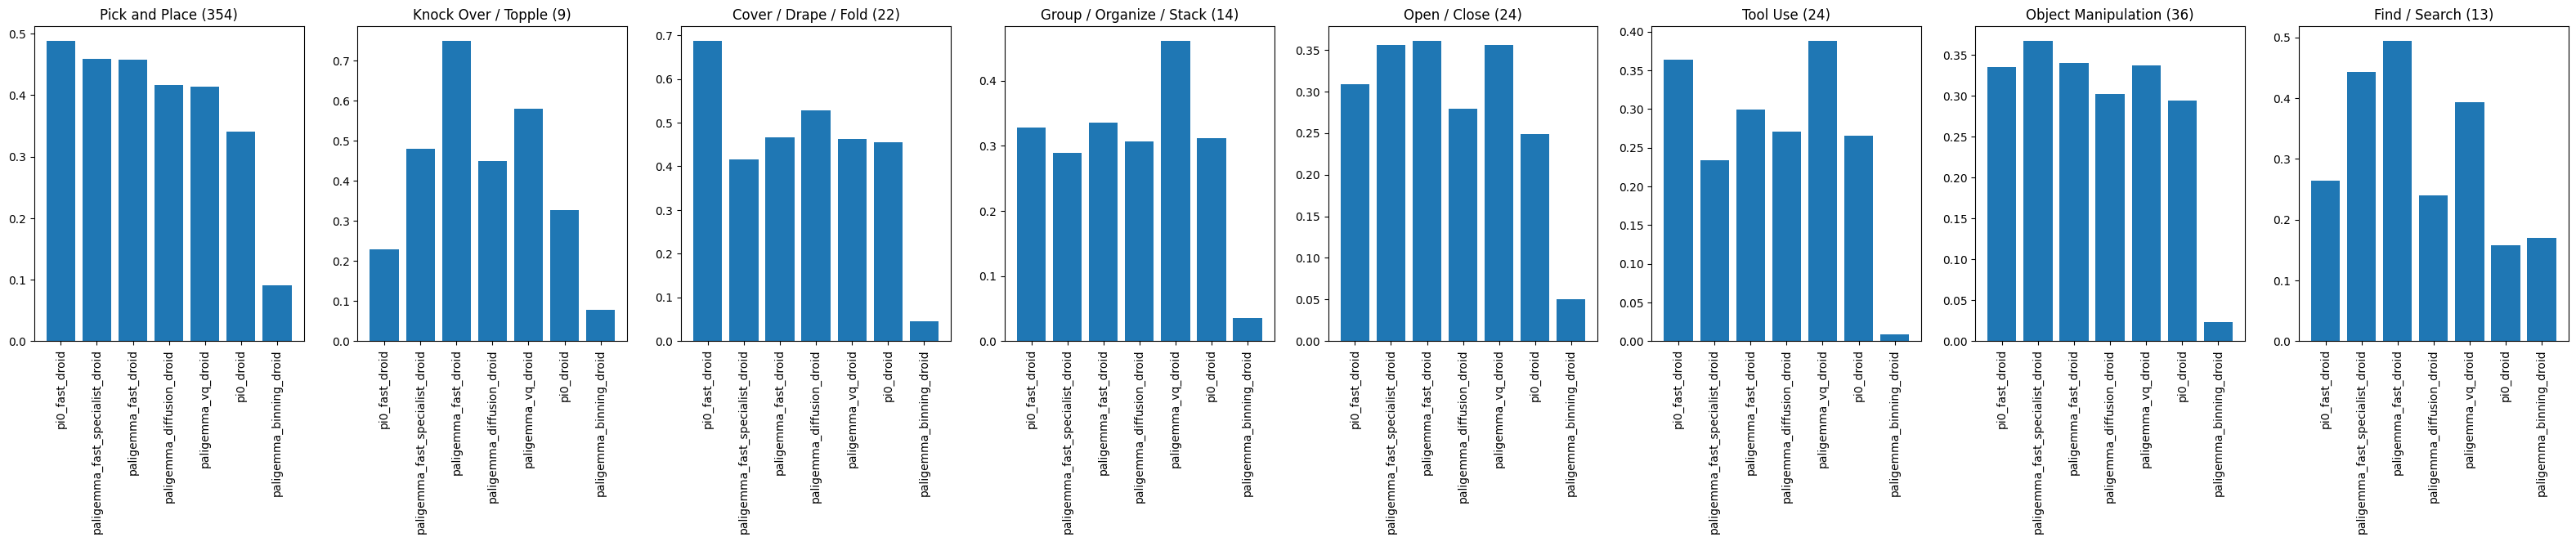

In [ ]:
# Plot Per Task scores
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, len(per_task_results), figsize=(5 * len(per_task_results), 5))

pols = list(per_task_results["Pick and Place"].policy)
for i, (task, tbl) in enumerate(per_task_results.items()):
  scores = []
  for p in pols:
    if p in list(tbl.policy):
      scores.append(tbl[tbl.policy == p].score.values[0])
    else:
      scores.append(np.nan)
  axs[i].bar(pols, scores)
  axs[i].set_xticklabels(pols, rotation=90)
  axs[i].set_title(task + f" ({int(per_task_samples[task]/7)})")

plt.show()

In [ ]:
# Split by Scene categories
per_category_results = {}
per_category_samples = {}

# obstructed_camera_view
task_uuids = [uuid for uuid, s in session_info.items() if s.clear_camera_view == False]
tdf = task_df[task_df.session_uuid.isin(task_uuids)]
print(f"Obstructed view, #Samples: {len(tdf)}")
if len(tdf) > 20:
  per_category_results["Obstructed view"] = compute_partial_success(tdf)
  per_category_samples["Obstructed view"] = len(tdf)

# poor_lighting
task_uuids = [uuid for uuid, s in session_info.items() if s.good_lighting == False]
tdf = task_df[task_df.session_uuid.isin(task_uuids)]
print(f"Poor lighting, #Samples: {len(tdf)}")
if len(tdf) > 20:
  per_category_results["Poor lighting"] = compute_partial_success(tdf)
  per_category_samples["Poor lighting"] = len(tdf)

# unclear_task_description
task_uuids = [uuid for uuid, s in session_info.items() if s.clear_task_description == False]
tdf = task_df[task_df.session_uuid.isin(task_uuids)]
print(f"Unclear task description, #Samples: {len(tdf)}")
if len(tdf) > 20:
  per_category_results["Unclear task description"] = compute_partial_success(tdf)
  per_category_samples["Unclear task description"] = len(tdf)

# complex_scene
task_uuids = [uuid for uuid, s in session_info.items() if s.simple_scene == False]
tdf = task_df[task_df.session_uuid.isin(task_uuids)]
print(f"Complex scene, #Samples: {len(tdf)}")
if len(tdf) > 20:
  per_category_results["Complex scene"] = compute_partial_success(tdf)
  per_category_samples["Complex scene"] = len(tdf)

# requires_reasoning
task_uuids = [uuid for uuid, s in session_info.items() if s.reasoning_required == True]
tdf = task_df[task_df.session_uuid.isin(task_uuids)]
print(f"Requires reasoning, #Samples: {len(tdf)}")
if len(tdf) > 20:
  per_category_results["Requires reasoning"] = compute_partial_success(tdf)
  per_category_samples["Requires reasoning"] = len(tdf)

Obstructed view, #Samples: 149
Poor lighting, #Samples: 123
Unclear task description, #Samples: 42
Complex scene, #Samples: 1268
Requires reasoning, #Samples: 128


<ipython-input-93-1586f0cffcd0>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-93-1586f0cffcd0>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-93-1586f0cffcd0>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-93-1586f0cffcd0>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(pols, rotation=90)
<ipython-input-93-1586f0cffcd0>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

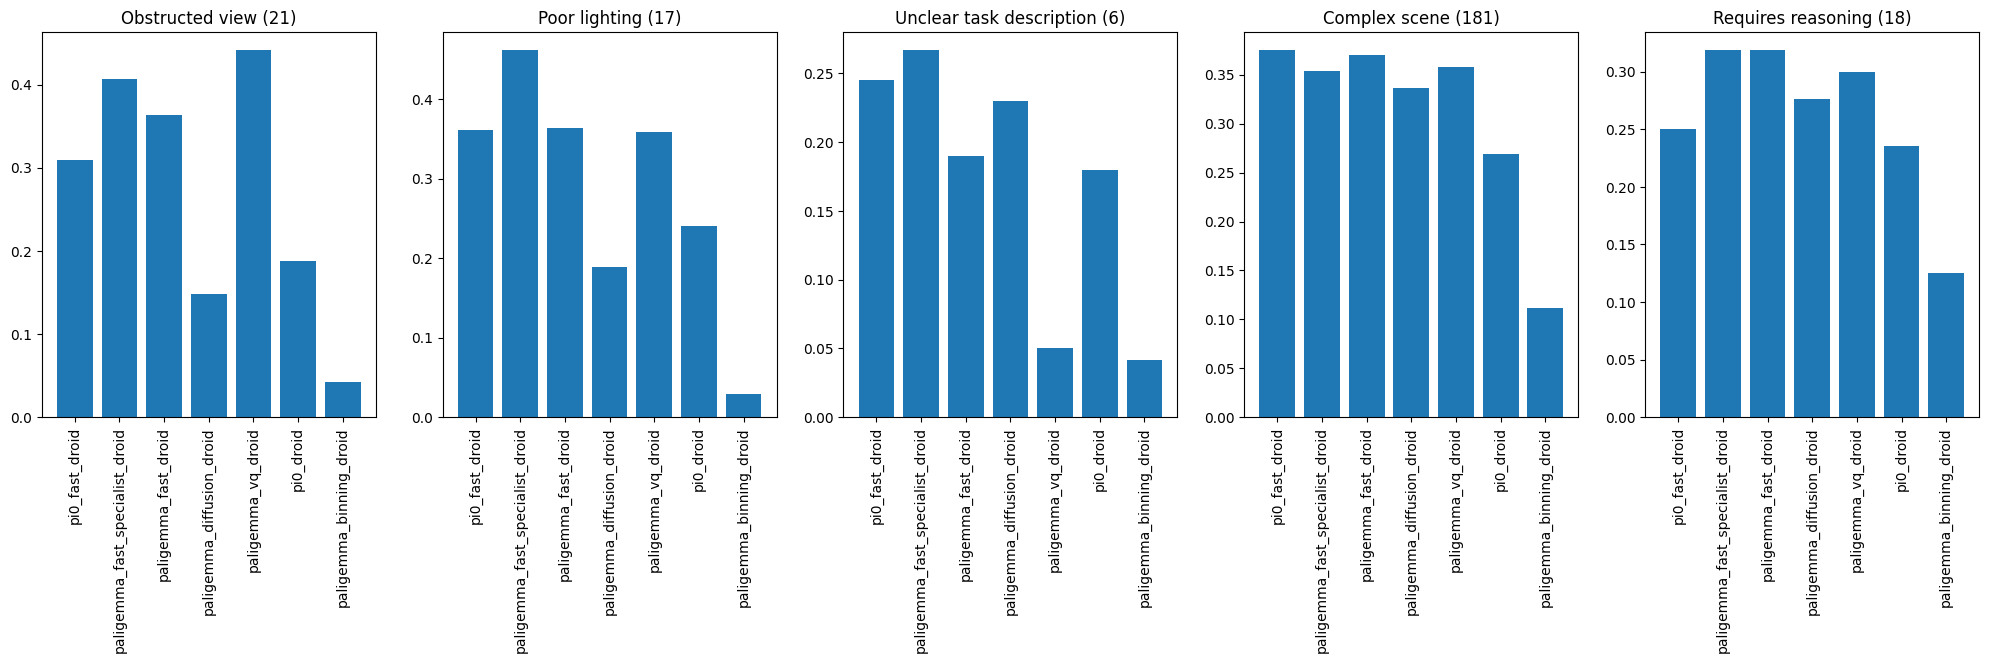

In [ ]:
# Plot Per Category scores
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, len(per_category_results), figsize=(5 * len(per_category_results), 5))

pols = list(per_task_results["Pick and Place"].policy)
for i, (category, tbl) in enumerate(per_category_results.items()):
  scores = []
  for p in pols:
    if p in list(tbl.policy):
      scores.append(tbl[tbl.policy == p].score.values[0])
    else:
      scores.append(np.nan)
  axs[i].bar(pols, scores)
  axs[i].set_xticklabels(pols, rotation=90)
  axs[i].set_title(category + f" ({int(per_category_samples[category]/7)})")

plt.show()

# [IGNORE] Ranking computations

In [ ]:
def bootstrap(fn, use_pref=True, bootstrap_rounds=100, pref_data=None):
  # Run algorithm over N random resamples of the data

  if pref_data is not None:
    pref_df = pref_data

  sid = np.unique(pref_df.sid)
  pol_scores = defaultdict(list)
  # metrics = defaultdict(list)
  for _ in tqdm.tqdm(range(bootstrap_rounds)):
    rng.shuffle(sid)

    train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
    test_pref  = pref_df[~pref_df.sid.isin(train_pref.sid)]

    train_data = train_pref
    test_data = test_pref
    if not use_pref:
      train_task = task_df[task_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
      test_task  = task_df[~task_df.sid.isin(train_task.sid)]
      train_data = train_task

    # Run algorithm
    results = fn(train_data)
    for _, r in results.iterrows():
      pol_scores[r.policy].append(r.score)

    # # Compute metrics
    # merged = results.merge(gt, on="policy", how="inner")

    # sc_vals = pd.to_numeric(merged["score"], errors="coerce").to_numpy(dtype=float)
    # gt_vals = pd.to_numeric(merged["gt"],    errors="coerce").to_numpy(dtype=float)
    # acc = accuracy(test_data, results)
    # gt_acc = accuracy(test_data, pd.DataFrame({"policy": merged.policy, "score": gt_vals}))
    # metrics["pearson"].append(pearson(sc_vals, gt_vals))
    # metrics["mmrv"].append(mmrv(sc_vals, gt_vals))
    # metrics["accuracy"].append(acc)
    # metrics["delta_accuracy"].append(max(gt_acc - acc, 0))

  mean_pol_scores = {pol: np.mean(scores) for pol, scores in pol_scores.items()}
  std_pol_scores = {pol: np.std(scores) for pol, scores in pol_scores.items()}
  ci_pol_scores = {pol: ci(scores) for pol, scores in pol_scores.items()}
  policies = list(mean_pol_scores.keys())

  # metrics = pd.DataFrame(
  #     {
  #         "metric": metrics.keys(),
  #         "score": [np.mean(scores) for scores in metrics.values()],
  #         "std": [np.std(scores) for scores in metrics.values()],
  #         "ci95": [ci(scores) for scores in metrics.values()]
  #     }
  # )
  return (
      pd.DataFrame(
          {
              "policy": policies,
              "score": [mean_pol_scores[p] for p in policies],
              "std": [std_pol_scores[p] for p in policies],
              "ci95": [ci_pol_scores[p] for p in policies]
          }
      )
      .sort_values("score", ascending=False)
      .reset_index(drop=True)
      # metrics
  )

In [ ]:
def em_hybrid(df, iters=EM_ITERS, step_clip: float = 1.0, l2_psi: float = 1e-2, scale=400, init_score=1500):
    pols = pd.unique(pd.concat([df.i, df.j]))
    idmap = {p: k for k, p in enumerate(pols)}
    P = len(pols)
    i = df.i.map(idmap).to_numpy()
    j = df.j.map(idmap).to_numpy()
    y = df.y.to_numpy()
    win, loss, tie = (y == 2), (y == 0), (y == 1)

    # θ = np.zeros(P)
    # τ = np.zeros(T_BUCKET)
    # ψ = np.zeros((P, T_BUCKET))
    θ = rng.normal(0., .1, P)
    τ = rng.normal(0., .1, T_BUCKET)
    ψ = rng.normal(0., .1, (P, T_BUCKET))
    π = np.full(T_BUCKET, 1 / T_BUCKET)
    ν = 0.5

    def clip_step(x, g, h):
        if abs(h) < 1e-8: return x
        return x - np.clip(g / h, -step_clip, step_clip)

    for _ in range(iters):
        δ_i = θ[i][:, None] + ψ[i]
        δ_j = θ[j][:, None] + ψ[j]
        logit = δ_i - δ_j - τ
        s_i = expit(logit)
        s_j = 1.0 - s_i

        p_win  = s_i * (1 - s_j)
        p_loss = (1 - s_i) * s_j
        p_tie  = 2 * ν * np.sqrt(p_win * p_loss)
        like = p_win * win[:, None] + p_loss * loss[:, None] + p_tie * tie[:, None]
        γ = π * np.clip(like, 1e12, None)
        γ /= γ.sum(1, keepdims=True)

        # θ update
        for pidx in range(P):
            mi, mj = (i == pidx), (j == pidx)
            g = h = 0.0
            for tt in range(T_BUCKET):
                si, sj = s_i[:, tt], s_j[:, tt]
                if mi.any():
                    di = si[mi] * (1 - si[mi]) + sj[mi] * (1 - sj[mi])
                    g += ((win[mi] * (1 - sj[mi]) - loss[mi] * sj[mi]
                           + tie[mi] * (sj[mi] - si[mi])) * γ[mi, tt]).sum()
                    h -= (di * γ[mi, tt]).sum()
                if mj.any():
                    dj = si[mj] * (1 - si[mj]) + sj[mj] * (1 - sj[mj])
                    g += ((loss[mj] * (1 - si[mj]) - win[mj] * si[mj]
                           + tie[mj] * (si[mj] - sj[mj])) * γ[mj, tt]).sum()
                    h -= (dj * γ[mj, tt]).sum()
            θ[pidx] = clip_step(θ[pidx], g, h)
        θ -= θ.mean()

        # ψ update
        for pidx in range(P):
            for tt in range(T_BUCKET):
                mi, mj = (i == pidx), (j == pidx)
                si, sj = s_i[:, tt], s_j[:, tt]
                g = h = 0.0
                if mi.any():
                    g += (( win[mi]*(1 - sj[mi]) - loss[mi]*sj[mi]
                          + tie[mi]*(sj[mi] - si[mi])) * γ[mi, tt]).sum()
                    h -= ((si[mi]*(1 - si[mi]) + sj[mi]*(1 - sj[mi]))
                          * γ[mi, tt]).sum()
                if mj.any():
                    g += (( loss[mj]*(1 - si[mj]) - win[mj]*si[mj]
                          + tie[mj]*(si[mj] - sj[mj])) * γ[mj, tt]).sum()
                    h -= ((si[mj]*(1 - si[mj]) + sj[mj]*(1 - sj[mj]))
                          * γ[mj, tt]).sum()
                g += l2_psi * ψ[pidx, tt]
                h -= l2_psi
                ψ[pidx, tt] = clip_step(ψ[pidx, tt], g, h)
        ψ -= ψ.mean(axis=1, keepdims=True)

        # τ update
        for tt in range(T_BUCKET):
            si, sj = s_i[:, tt], s_j[:, tt]
            g = ((γ[:, tt] *
                  (win * (-si * (1 - sj)) +
                   loss * (sj * (1 - si)) +
                   tie * (si - sj) * 0.5)).sum())
            h = -((γ[:, tt] * (si * (1 - si) + sj * (1 - sj))).sum())
            τ[tt] = clip_step(τ[tt], g, h)
        τ -= τ.mean()

        π = γ.mean(0)
        π /= π.sum()
        ν = 0.5 * ((p_tie * γ).sum() / max((p_win * γ).sum(), 1e-9))

    # θ[~np.isfinite(θ)] = 0
    board = pd.DataFrame({"policy": pols, "score": θ}).sort_values("score", ascending=False)
    return board.reset_index(drop=True)#, τ, π

tbl_hy = bootstrap(em_hybrid, pref_data=pref_df)
display(tbl_hy)

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


,policy,score,std,ci95
0,pi0_fast_droid,42.727082,7.740752,1.543671
1,paligemma_fast_specialist_droid,41.474486,7.706334,1.536807
2,paligemma_vq_droid,38.920985,13.689421,2.729962
3,paligemma_fast_droid,37.810979,15.528788,3.096771
4,paligemma_diffusion_droid,-21.046534,39.789397,7.934853
5,pi0_droid,-66.806937,12.653682,2.523414
6,paligemma_binning_droid,-73.080062,7.648399,1.525254


<ipython-input-60-9b8b36faaadd>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tbl_hy.policy, rotation=90)


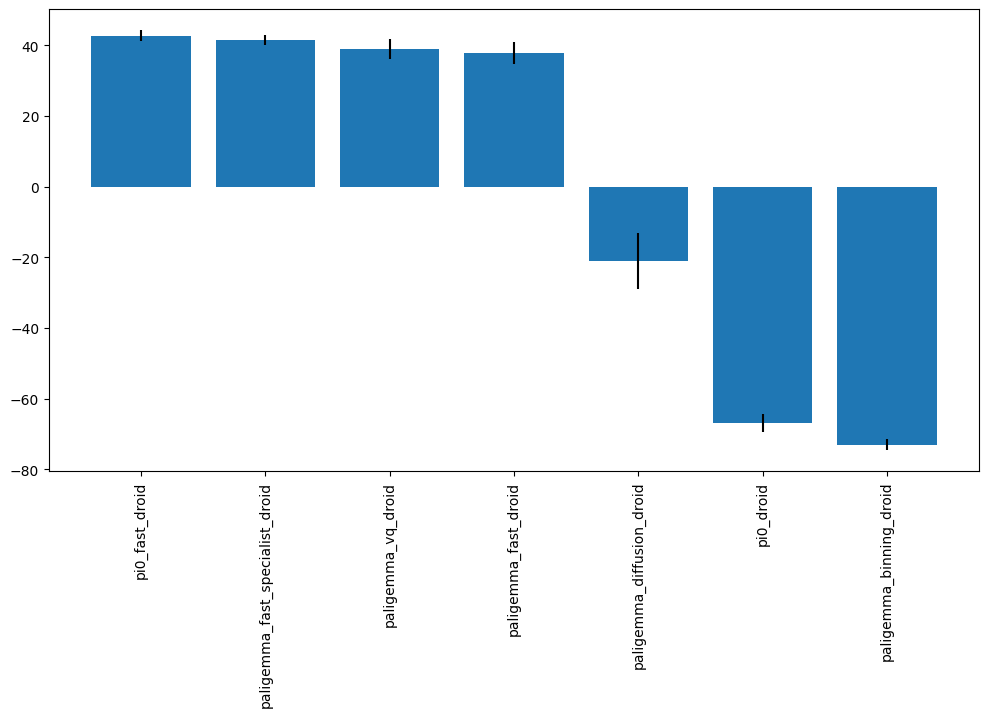

In [ ]:
# Plot scores
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.bar(tbl_hy.policy, tbl_hy.score, yerr=tbl_hy.ci95)
ax.set_xticklabels(tbl_hy.policy, rotation=90)
# ax.set_ylim(1100, 1600)
plt.show()

In [ ]:
# Split by Task type
task_types = set(s.task_category for _, s in session_info.items())

per_task_results = {}
for task in task_types:
  task_uuids = [uuid for uuid, s in session_info.items() if s.task_category == task]
  task_df = pref_df[pref_df.session_uuid.isin(task_uuids)]
  print(f"Task: {task}, #Samples: {len(task_df)}")
  if len(task_df) < 20: continue
  per_task_results[task] = bootstrap(em_hybrid, pref_data=task_df)

Task: Pick and Place, #Samples: 355


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Task: Sorting / Classification, #Samples: 5
Task: Minimal or No Action, #Samples: 3
Task: Knock Over / Topple, #Samples: 11
Task: Cover / Drape / Fold, #Samples: 22


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Task: Group / Organize / Stack, #Samples: 14
Task: Open / Close, #Samples: 24


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Task: Tool Use, #Samples: 24


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Task: Object Manipulation, #Samples: 36


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]

Task: Find / Search, #Samples: 16
Task: Move / Slide, #Samples: 7


<ipython-input-72-501614396a96>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(tbl_hy.policy, rotation=90)
<ipython-input-72-501614396a96>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i + 1].set_xticklabels(pols, rotation=90)
<ipython-input-72-501614396a96>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i + 1].set_xticklabels(pols, rotation=90)
<ipython-input-72-501614396a96>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i + 1].set_xticklabels(pols, rotation=90)
<ipython-input-72-501614396a96>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

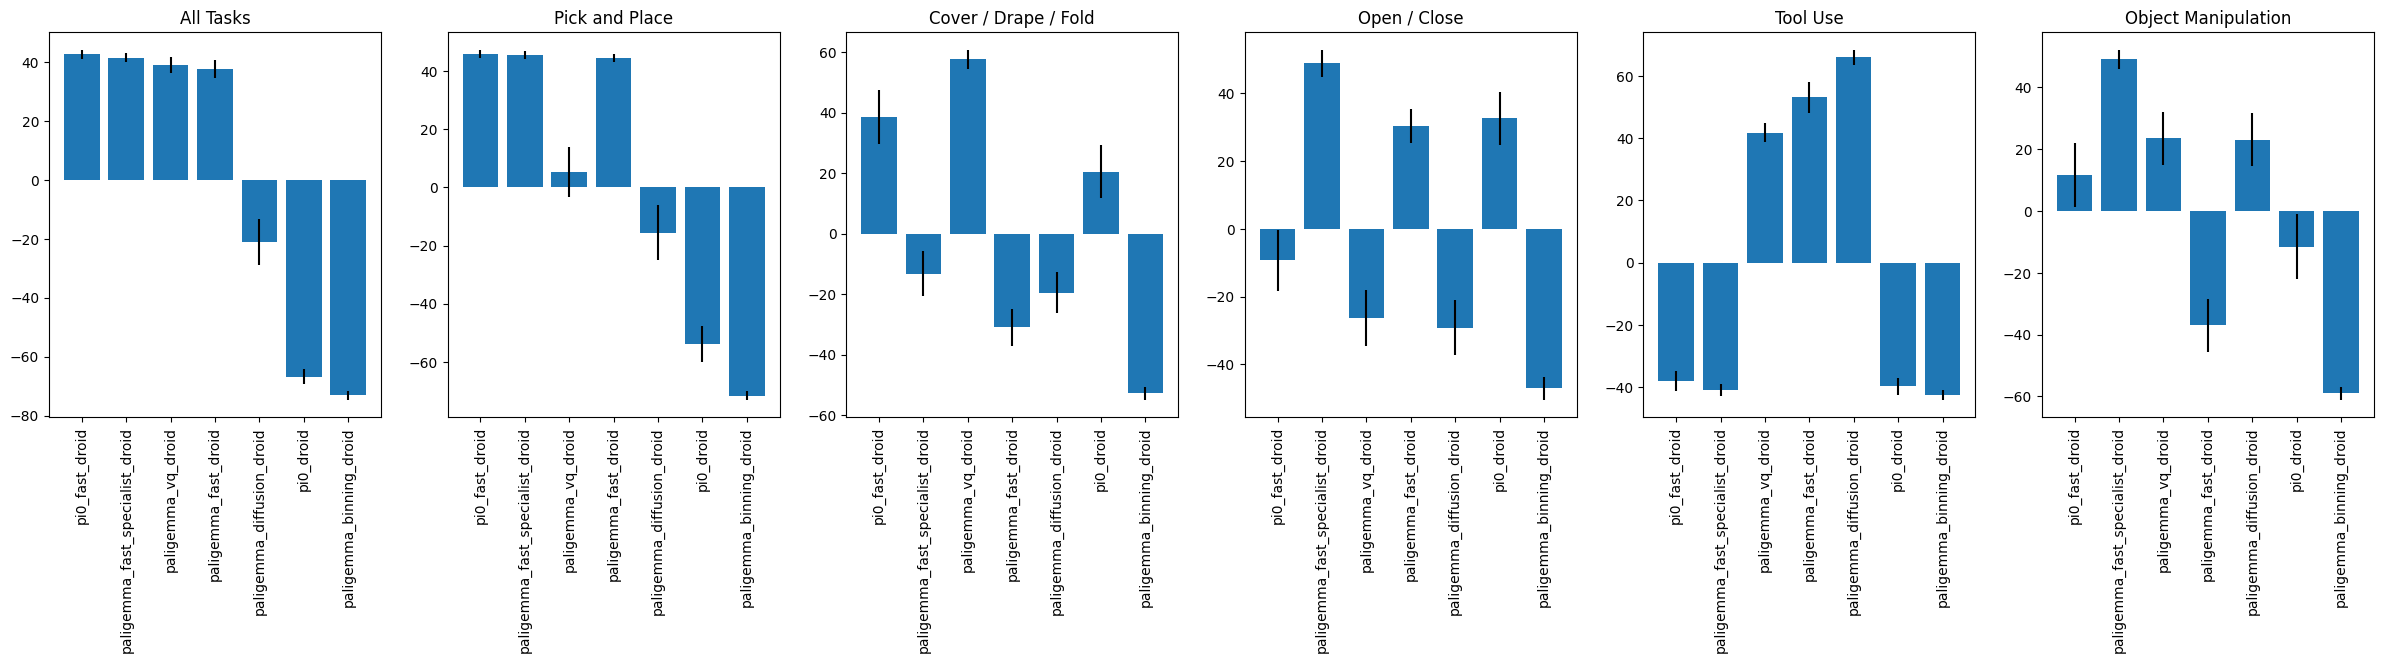

In [ ]:
# Plot Per Task scores
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, len(per_task_results) + 1, figsize=(5 * (len(per_task_results) + 1), 5))
axs[0].bar(tbl_hy.policy, tbl_hy.score, yerr=tbl_hy.ci95)
axs[0].set_xticklabels(tbl_hy.policy, rotation=90)
# axs[0].set_ylim(1100, 1600)
axs[0].set_title("All Tasks")

pols = list(tbl_hy.policy)
for i, (task, tbl) in enumerate(per_task_results.items()):
  scores = []
  cis = []
  for p in pols:
    if p in list(tbl.policy):
      scores.append(tbl[tbl.policy == p].score.values[0])
      cis.append(tbl[tbl.policy == p].ci95.values[0])
    else:
      scores.append(np.nan)
      cis.append(np.nan)
  axs[i + 1].bar(pols, scores, yerr=cis)
  axs[i + 1].set_xticklabels(pols, rotation=90)
  # axs[i + 1].set_ylim(1100, 1600)
  axs[i + 1].set_title(task)

plt.show()

In [ ]:
# Split by Scene categories
per_category_results = {}

# obstructed_camera_view
task_uuids = [uuid for uuid, s in session_info.items() if s.clear_camera_view == False]
task_df = pref_df[pref_df.session_uuid.isin(task_uuids)]
print(f"Obstructed view, #Samples: {len(task_df)}")
if len(task_df) > 20:
  per_category_results["Obstructed view"] = bootstrap(em_hybrid, pref_data=task_df)

# poor_lighting
task_uuids = [uuid for uuid, s in session_info.items() if s.good_lighting == False]
task_df = pref_df[pref_df.session_uuid.isin(task_uuids)]
print(f"Poor lighting, #Samples: {len(task_df)}")
if len(task_df) > 20:
  per_category_results["Poor lighting"] = bootstrap(em_hybrid, pref_data=task_df)

# unclear_task_description
task_uuids = [uuid for uuid, s in session_info.items() if s.clear_task_description == False]
task_df = pref_df[pref_df.session_uuid.isin(task_uuids)]
print(f"Unclear task description, #Samples: {len(task_df)}")
if len(task_df) > 20:
  per_category_results["Unclear task description"] = bootstrap(em_hybrid, pref_data=task_df)

# complex_scene
task_uuids = [uuid for uuid, s in session_info.items() if s.simple_scene == False]
task_df = pref_df[pref_df.session_uuid.isin(task_uuids)]
print(f"Complex scene, #Samples: {len(task_df)}")
if len(task_df) > 20:
  per_category_results["Complex scene"] = bootstrap(em_hybrid, pref_data=task_df)

# requires_reasoning
task_uuids = [uuid for uuid, s in session_info.items() if s.reasoning_required == True]
task_df = pref_df[pref_df.session_uuid.isin(task_uuids)]
print(f"Requires reasoning, #Samples: {len(task_df)}")
if len(task_df) > 20:
  per_category_results["Requires reasoning"] = bootstrap(em_hybrid, pref_data=task_df)

Obstructed view, #Samples: 23


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Poor lighting, #Samples: 18
Unclear task description, #Samples: 6
Complex scene, #Samples: 182


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

Requires reasoning, #Samples: 20


<ipython-input-74-f853d692c560>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(tbl_hy.policy, rotation=90)
<ipython-input-74-f853d692c560>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i + 1].set_xticklabels(pols, rotation=90)
<ipython-input-74-f853d692c560>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i + 1].set_xticklabels(pols, rotation=90)


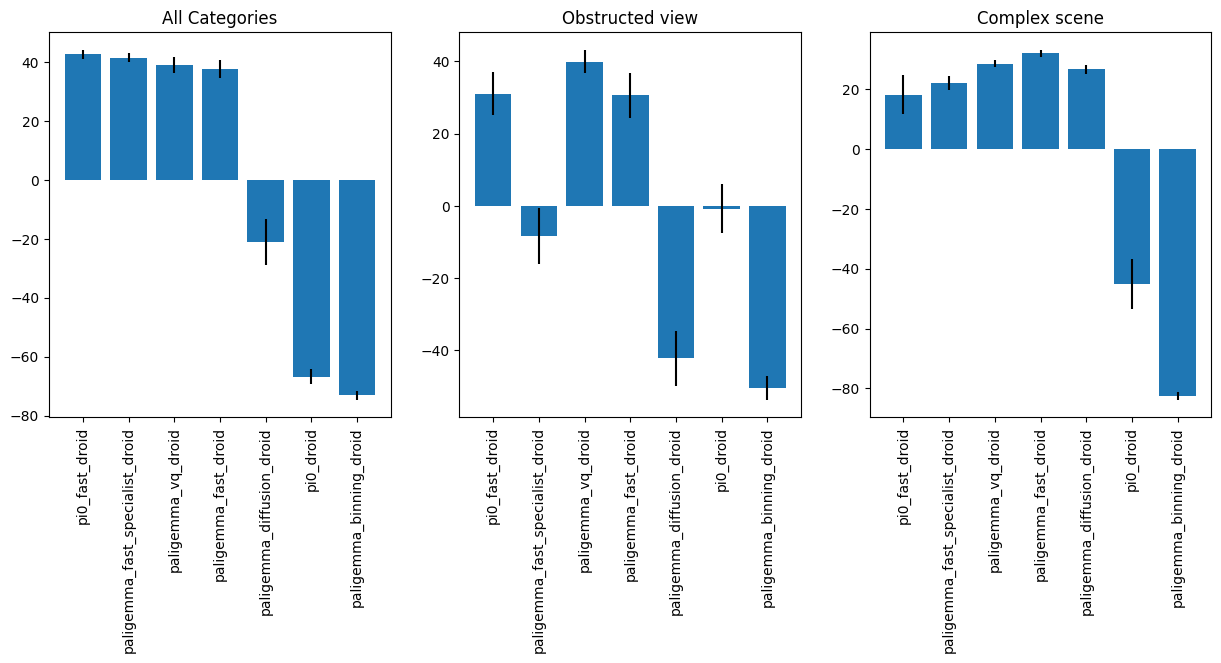

In [ ]:
# Plot Per Category scores
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, len(per_category_results) + 1, figsize=(5 * (len(per_category_results) + 1), 5))
axs[0].bar(tbl_hy.policy, tbl_hy.score, yerr=tbl_hy.ci95)
axs[0].set_xticklabels(tbl_hy.policy, rotation=90)
# axs[0].set_ylim(1100, 1600)
axs[0].set_title("All Categories")

pols = list(tbl_hy.policy)
for i, (category, tbl) in enumerate(per_category_results.items()):
  scores = []
  cis = []
  for p in pols:
    if p in list(tbl.policy):
      scores.append(tbl[tbl.policy == p].score.values[0])
      cis.append(tbl[tbl.policy == p].ci95.values[0])
    else:
      scores.append(np.nan)
      cis.append(np.nan)
  axs[i + 1].bar(pols, scores, yerr=cis)
  axs[i + 1].set_xticklabels(pols, rotation=90)
  # axs[i + 1].set_ylim(1100, 1600)
  axs[i + 1].set_title(category)

plt.show()